# Local likelihood optimization

In the previous notebook, we went through the calculation of the likelihood function for an HMM and explicitly minimized it. Specifically, we looked at a situation where the transition rate and emission probability matrices took the form

$$ \boldsymbol{A} = \left[ \begin{matrix} 1 - a & a \\ a & 1 - a \end{matrix} \right] $$

and 

$$ \boldsymbol{B} = \left[ \begin{matrix} 1 - b & b \\ b & 1 - b \end{matrix} \right] $$

respectively, then we estimated the parameters $a$ and $b$ given an observed sequence of states.

*A priori* we will not know what the hidden state sequence was (it is hidden, after all...) So, to deal with this we would need to calculate the likelihood over all possible hidden state sequences, and all parameter values in the $A$ and $B$ matrices. This problem will quickly become very high dimensional, and as a result we must resort to other methods. Specifically, we can perform a local optimization routine on the parameter space, for a given initial starting point.

In this notebook, we will first build a custom gradient descent algorithm to track the evolution of the parameter vector over iterations, and then use these results to validate a more efficient implementation using a `scipy.optimize.minimize` function to do the heavy lifting.

#### Gradient descent

Given that we are trying to minimize the likelihood function $\mathcal{L}(\theta)$, for parameter vector $\theta$, the general form of a gradient descent algorithm will update the value of the parameter vector $\theta_i \to \theta_{i+1}$ as

$$ \theta_{i+1} = \theta_i - \eta \nabla \mathcal{L}(\theta_i) $$

where $\nabla$ is the gradient of the likelihood function and $\eta$ is the *learning rate* which determines how large the update steps are. For an initial implementation, we take the learning rate to be constant, but there are many schemes that optimize this parameter by dynamically updating it so that the solution converges towards a local minimum more rapidly.  In order to calculate the derivative of the likelhood function, we will use a simple first-order difference in the likelihood function, approximating each component of the gradient with a simple first-difference

$$ \partial_{\theta^k}\mathcal{L}(\theta_i) \approx \frac{1}{2 \Delta\theta^{k}} \left[ \mathcal{L}(\theta + \Delta\theta^{k}) - \mathcal{L}(\theta - \Delta\theta^{k}) \right] $$

where $\Delta\theta^k$ is chosen to be small.  This procedure requires two evaluations of the likelihood function per dimension of the parameter vector for each iterative update to $\theta$.


In [19]:
# First, import the necessary packages and generate a the dynamics of an example HMM
import os
import numpy as np
from typing import Iterable, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

# Import HMM libraries
from hidden import dynamics
from hidden import infer
from pathlib import Path

# here we assume the dynamics are symmetric
a = 0.3
b = 0.1

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [20]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 500 steps
hmm.run_dynamics(1000)
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

In [12]:
def calc_likelihood(
    B: np.ndarray,
    bayes_pred: Iterable[np.ndarray],
    obs_ts: Iterable[int]
) -> float:
    likelihood = 0
    for bayes, obs in zip(bayes_pred, obs_ts):
        inner =  bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood

In [21]:

def _build_hmm_parameters(theta: np.ndarray) -> Tuple:
    # Based on convention of what the parameters are, this function will return
    # the A and B matrices based on the input parameter vector
    # Here it is assumed that theta = (a, b)
    A = theta[0] * np.ones((2, 2))
    B = theta[1] * np.ones((2, 2))

    A[0, 0], A[1, 1] = 1 - theta[0], 1 - theta[0]
    B[0, 0], B[1, 1] = 1 - theta[1], 1 - theta[1]

    return A, B


def _get_likelihood_deriv(
    curr_theta: np.ndarray,
    obs_ts: np.ndarray,
    est: infer.MarkovInfer,
    delta: Optional[float] = 0.01
) -> np.ndarray:

    grad = np.zeros_like(curr_theta)

    for i in range(len(curr_theta)):
        plus_theta = np.copy(curr_theta)
        minus_theta = np.copy(curr_theta)

        plus_theta[i] += delta
        minus_theta[i] -= delta

        A_plus, B_plus = _build_hmm_parameters(plus_theta)
        A_minus, B_minus = _build_hmm_parameters(minus_theta)

        est.forward_algo(obs_ts, A_plus, B_plus, prediction_tracker=True)
        bayes_plus = np.copy(est.predictions)
        est.forward_algo(obs_ts, A_minus, B_minus, prediction_tracker=True)
        bayes_minus = np.copy(est.predictions)

        likelihood_plus = calc_likelihood(B_plus, bayes_plus, obs_ts)
        likelihood_minus = calc_likelihood(B_minus, bayes_minus, obs_ts)

        grad[i] = (likelihood_plus - likelihood_minus) / (2 * delta)

    return grad

def grad_descent(
    obs_ts: Iterable[int],
    init_theta: np.ndarray,
    learning_rate: Optional[float] = 0.0002,
    max_iterations: Optional[int] = 500,
    tolerance: Optional[float] = 0.00000001,
    output: Optional[bool] = False
) -> np.ndarray:

    curr_theta = np.copy(init_theta)
    est = infer.MarkovInfer(2, 2)

    # Calculate likelihood of initial guess
    A, B = _build_hmm_parameters(init_theta)
    est.forward_algo(obs_ts, A, B, prediction_tracker=True)
    lkly = calc_likelihood(B, est.predictions, obs_ts)

    # Initialize tracking arrays
    likelihood_tracker = [lkly]
    param_tracker = [init_theta]

    # Apply grad descent interations
    for i in range(max_iterations):
        if 1%50 == 0:
            print(f"-- Iteration: {i} (of {max_iterations}) --")

        grad = _get_likelihood_deriv(curr_theta, obs_ts, est)
        if output: print(f"grad --> {grad}")
        curr_theta -= learning_rate * grad

        A, B = _build_hmm_parameters(curr_theta)
        est.forward_algo(obs_ts, A, B, prediction_tracker=True)
        lkly_new = calc_likelihood(B, est.predictions, obs_ts)

        likelihood_tracker.append(lkly_new)
        param_tracker.append(np.copy(curr_theta))

        # If changes in likelihood are lower than tolerance break the loop
        #if lkly_new - lkly < tolerance:
        #    print("--- Tolerance level hit, exiting grad-descent ---")
        #    break
        # If not, update the current likelihood value and repeat
        #else:
        #    lkly = lkly_new
        lkly = lkly_new

    return likelihood_tracker, param_tracker


In [28]:
# So, now we can run this for an initial guess

# ACTUAL PARAMETERS
# a = 0.3
# b = 0.1
param_init_set = [
    [0.45, 0.02],
    [0.4, 0.2],
    [0.2, 0.05],
    [0.15, 0.25]
]

l_res, theta_res = [], []

for i, param_init in enumerate(param_init_set):
    print(f"Working on param set {i + 1} of {len(param_init_set)}...")
    l_tracker, theta_tracker = grad_descent(obs_ts, param_init)
    l_res.append(l_tracker)
    theta_res.append(theta_tracker)


Working on param set 0 of 4...
Working on param set 1 of 4...
Working on param set 2 of 4...
Working on param set 3 of 4...


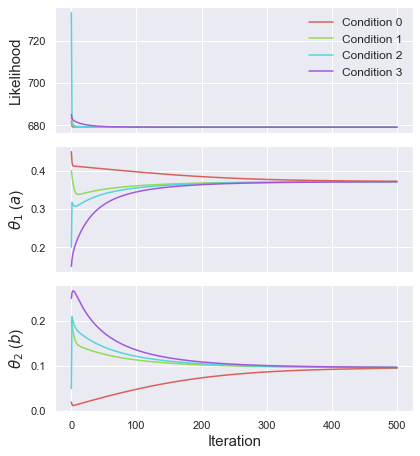

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6.5), sharex=True)
Pal = sns.color_palette('hls', len(l_res))
for i, (l, t) in enumerate(zip(l_res, theta_res)):
    ax[0].plot(l, color=Pal[i], label=f"Condition {i}")
    ax[1].plot([param[0] for param in t], color=Pal[i])
    ax[2].plot([param[1] for param in t], color=Pal[i])

ax[0].set_ylabel(r"Likelihood", fontsize=15)
ax[1].set_ylabel(r"$\theta_{1}$ ($a$)", fontsize=15)
ax[2].set_ylabel(r"$\theta_{2}$ ($b$)", fontsize=15)
ax[2].set_xlabel(r"Iteration", fontsize=15)

ax[0].legend(fontsize=12, frameon=False)

plt.tight_layout()


In [43]:
# We can also, like in the previous notebook, detemine the likelihood function over the eitnre parameter space.
def generate_likelihood_surface(
    obs_ts: Iterable[int], sample_dim: Optional[int] = 10
):
    est = infer.MarkovInfer(2, 2)

    a_vals = np.linspace(0.01, 0.99, sample_dim)
    b_vals = np.linspace(0.01, 0.99, sample_dim)

    likelihood = np.zeros((sample_dim, sample_dim))

    for i, a in enumerate(a_vals):
        A_sample = np.array([[1 - a, a], [a, 1 - a]])
        for j, b in enumerate(b_vals):
            B_sample = np.array([[1 - b, b], [b, 1 - b]])

            est.forward_algo(obs_ts, A_sample, B_sample, prediction_tracker=True)
            try:
                l = calc_likelihood(B_sample, est.predictions, obs_ts)
            except RuntimeWarning:
                l = None
            likelihood[i, j] = l

    return likelihood, a_vals, b_vals

# NOTE This cell takes a long time ~ 2.5 mins to run
likelihood_mat, aVals_arr, bVals_arr = generate_likelihood_surface(obs_ts, sample_dim=100)

In [45]:
# Format likelihood matrix into dataframe so that index coordinates are correctly mapped
import pandas as pd
df_lkly = pd.DataFrame(likelihood_mat)
df_lkly.columns = bVals_arr
df_lkly.index = aVals_arr
df_lkly.head()

,0.010000,0.019899,0.029798,0.039697,0.049596,0.059495,0.069394,0.079293,0.089192,0.099091,...,0.900909,0.910808,0.920707,0.930606,0.940505,0.950404,0.960303,0.970202,0.980101,0.990000
0.010000,1314.661209,1201.296724,1128.864571,1075.208440,1032.388835,996.778153,966.405997,940.038766,916.829739,896.167390,...,896.167390,916.829739,940.038766,966.405997,996.778153,1032.388835,1075.208440,1128.864571,1201.296724,1314.661209
0.019899,1219.312156,1125.019645,1063.459751,1017.276538,980.324623,949.551667,923.227077,900.289120,880.040688,861.994083,...,861.994083,880.040688,900.289120,923.227077,949.551667,980.324623,1017.276538,1063.459751,1125.019645,1219.312156
0.029798,1157.071062,1073.367003,1019.052319,978.034779,945.026121,917.468965,893.883569,873.331809,855.184998,839.003388,...,839.003388,855.184998,873.331809,893.883569,917.468965,945.026121,978.034779,1019.052319,1073.367003,1157.071062
0.039697,1110.099671,1033.807858,984.642023,947.545259,917.616080,892.568790,871.104948,852.398684,835.888343,821.175022,...,821.175022,835.888343,852.398684,871.104948,892.568790,917.616080,947.545259,984.642023,1033.807858,1110.099671
0.049596,1071.683158,1001.579651,956.407210,922.410831,894.987520,872.015384,852.312292,835.134936,819.978170,806.480821,...,806.480821,819.978170,835.134936,852.312292,872.015384,894.987520,922.410831,956.407210,1001.579651,1071.683158


Text(30.5, 0.5, 'b')

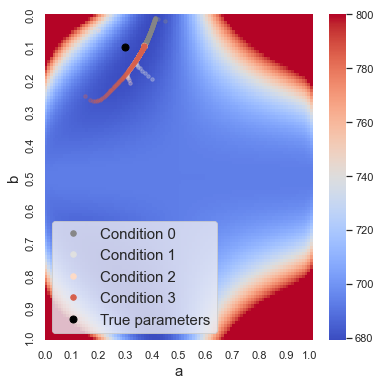

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#Pal = sns.color_palette("Spectral", len(theta_tracker))
Pal = sns.color_palette('RdGy', 4)

alpha_map = np.linspace(0.2, 0.8, len(l_res[0]))

sns.heatmap(likelihood_mat.T, cmap='coolwarm', ax=ax, vmax=800)

for i, (l, t) in enumerate(zip(l_res, theta_res)):
    color =  Pal[i]
    for j, theta in enumerate(t):
        ax.plot([theta[0] * 100], [theta[1] * 100], 'o', markersize=3.5, color=Pal[3-i], alpha=0.3)
    ax.plot([theta[0] * 100], [theta[1] * 100], 'o', markersize=5.5, color=Pal[3-i], label=f"Condition {i}")

ax.plot(a * 100, b * 100, 'o', color='k', markersize=7, label="True parameters")
ax.legend(fontsize=15)

idx_arr = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

ax.set_xticks(idx_arr)
ax.set_yticks(idx_arr)

ax.set_xticklabels(np.round(aVals_arr[idx_arr], 1))
ax.set_yticklabels(np.round(aVals_arr[idx_arr], 1))

ax.set_xlabel(r"a", fontsize=15)
ax.set_ylabel(r"b", fontsize=15)

So, here we can see that, the gradient descent algorithm is, in fact, able to locate the function minimum. In each case, the solution iteratesdown to the basin moving in the general $b = ma + c$ direction, and then moves along the bottom of that basin until convergence. Furthermore, the solutions all find the same final parameter vector, which is promising. However, this would not be the case when we initialized a parameter vector closer to the symmetric basin on the otehr side of $b=1/2$, or near $a=1, b=1/2$.  

Finally, one point of concern to watch is the non-monotonic behaviour of convergence in each solution. Ultimately, this is because the derivative of the likelihood near the boundaries of the domain gets very large, so even for small learning rates, this could lead to out-of-bounds behaviours, or unexpected numerical results in cases where we dont pay close attention. To remedy this, we could, for instance, introduce an adaptive learning rate that will be smaller when close to the boundaries, or, in a more extremem case, regularize the derivative terms so that we only really care about the direction of the update, and not its magnitude. 

Next, we turn to the infrastructure of `scipy.optimize` to let a more robust optimization algorithm(s) take on the heavy lifting, so that we can be more sure of its robustness, and test a arger variety of optimization techniques.

In [80]:
# As an alternate approach, we can use a built-in optimizer from scipy
import scipy.optimize

# however, to do that efficiently we need to redefine the objective function
def calc_likelihood_optimizer(
    param_arr: Iterable, obs_ts: Iterable, est: infer.MarkovInfer
) -> float:
    A, B = _build_hmm_parameters(param_arr)
    est.forward_algo(obs_ts, A, B, prediction_tracker=True)

    likelihood = 0
    for bayes, obs in zip(est.predictions, obs_ts):
        inner = bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood

est = infer.MarkovInfer(2, 2)
# Initial parameters for optimization
param_init = [0.4, 0.4]
A, B = _build_hmm_parameters(param_init)
est.forward_algo(obs_ts, A, B, prediction_tracker=True)

bnds = ([0.001, 0.99], [0.001 ,0.99])

In [90]:


# Sequential Least-Squares Progarmming (SLSQP) optimizer (that allows bounds)
def lkly_opt(method: str):
    return scipy.optimize.minimize(
        calc_likelihood_optimizer,
        param_init,
        args=(obs_ts, est),
        method=method,
        bounds=bnds
    )

%timeit lkly_opt("SLSQP")


439 ms ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:

# Nelder-Mead
%timeit lkly_opt('Nelder-Mead')

669 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%timeit lkly_opt('L-BFGS-B')

468 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
%timeit lkly_opt('TNC')

987 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [103]:
# If no method is selected, the algo automatically selects one of SLSQP,
# L-BFGS-B, or BFGS, depending on whether bounds or constraints are present
%timeit lkly_opt(None)

473 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
res_slsqp = lkly_opt('SLSQP')
res_slsqp

     fun: 678.9652739793319
     jac: array([-6.10351562e-05,  4.73022461e-04])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([0.37243622, 0.09501441])

In [104]:
res_nelder = lkly_opt('Nelder-Mead')
res_nelder

 final_simplex: (array([[0.37244296, 0.09500842],
       [0.37247327, 0.09495839],
       [0.37246229, 0.09495538]]), array([678.96527399, 678.96527407, 678.96527414]))
           fun: 678.965273986918
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 35
        status: 0
       success: True
             x: array([0.37244296, 0.09500842])

In [106]:
res_bfgs = lkly_opt('L-BFGS-B')
res_bfgs

      fun: 678.9652739818807
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00378577, -0.0020691 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 10
     njev: 16
   status: 0
  success: True
        x: array([0.37243669, 0.09501013])

In [88]:
# Finally, we can also look at global optimizer: Simplical Homology for Global Optimization (SHGO)
# To find the set of all local minima

def opt_shgo():
    return scipy.optimize.shgo(
        calc_likelihood_optimizer,
        bounds=bnds,
        args=(obs_ts, est),
        sampling_method='sobol'
    )

%timeit opt_shgo()


3.53 s ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
res_shgo = opt_shgo()
res_shgo

     fun: 678.965273977822
    funl: array([678.96527398, 678.96527398, 678.96527398, 678.96527398,
       678.96527398])
 message: 'Optimization terminated successfully.'
    nfev: 366
     nit: 2
   nlfev: 238
   nlhev: 0
   nljev: 56
 success: True
       x: array([0.37244025, 0.90499237])
      xl: array([[0.37244025, 0.90499237],
       [0.3724403 , 0.90499247],
       [0.37244036, 0.09500745],
       [0.37244031, 0.09500746],
       [0.37244037, 0.9049926 ]])

Here we can see that there are two distinct minima (local) found by the global optimizer at a = 0.37 and b = 0.90, 0.10, which are degenerate global minima. In the earlier stages, when we start closest to the (0.37, 0.10) minima. Further, we can look at the run-times for a few algorithms, and find that (of those tested), the SLSQP algorithm has the fastest runtime, and the 'L-BFGS-B' has a comparable runtime. In any case, however, the runtime for the built-in optimizers is significantly improved upon the naive implementation of gradient descent.

